In [1]:
!pip install git+https://github.com/ia-ML/segmentation_models

  Cloning https://github.com/ia-ML/segmentation_models to /tmp/pip-req-build-pyix6kdv
  Running command git clone --filter=blob:none --quiet https://github.com/ia-ML/segmentation_models /tmp/pip-req-build-pyix6kdv
  Resolved https://github.com/ia-ML/segmentation_models to commit 6c9a4cd0193291157e90df1945f4b0714a5d55fb
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.1 MB/s eta 0:00:00
  Created wheel for segmentation_models: filename=segmentation_models-1.0.1-py3-none-any.whl size=34263 sha256=54adffc867d3ca620a3496246bfdc800af4c96aed3c438b1d1753219e6efcd07
  Stored in directory: /tmp/pip-ephem-wheel-cache-637xydg1/wheels/b9/9c/ad/941476e5a2d98a5e44c163e15f43abbff888a159dbedbf1be3
Successfully built segmentation_models


In [2]:
# https://github.com/ia-ML/segmentation_models
import os
import keras
import numpy as np
import pandas as pd
from glob import glob
import tensorflow as tf
from keras.metrics import *
from keras.models import Model
import matplotlib.pyplot as plt
import segmentation_models as sm
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.layers import Activation, MaxPool2D, Concatenate
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

EPOCHS   = 250

2024-06-22 19:42:27.020924: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-22 19:42:27.021058: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-22 19:42:27.143616: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Segmentation Models: using `tf.keras` framework.


In [3]:
!nvidia-smi

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Sat Jun 22 19:42:37 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              27W / 250W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
#keras.backend.set_image_data_format('channels_last') # mirar si se tiene que cambiar por tf.keras

In [5]:
current_path = '/kaggle/working/'
data_path    = '/kaggle/input/denoised-maestria-npy/02 - Denoised' # cambiar esta por el input

print(current_path)
print(data_path)

/kaggle/working/
/kaggle/input/denoised-maestria-npy/02 - Denoised


In [6]:
n_classes   = 5
IMG_HEIGHT  = 256
IMG_WIDTH   = 256
BATCH_SIZE  = 32

class_names = [0, 1, 2, 3, 4]
seed        = 42
tf.random.set_seed(seed=42)

In [7]:
def parse_image_and_mask(image_path, mask_path):
    # Convert tensor to string
    image_path = image_path.numpy().decode('utf-8')
    mask_path = mask_path.numpy().decode('utf-8')

    # Load the image
    image = np.load(image_path)
    image = np.expand_dims(image, axis=-1)  # Add a channel dimension
    image = tf.convert_to_tensor(image, dtype=tf.float32)

    # Load the mask
    mask = np.load(mask_path)
    mask = np.expand_dims(mask, axis=-1)  # Add a channel dimension
    mask = tf.convert_to_tensor(mask, dtype=tf.int32)
    mask = tf.squeeze(mask, axis=-1)  # Remove the extra channel dimension
    mask = tf.one_hot(mask, depth=n_classes)  # Depth is 5 for classes 0 to 4
    
    return image, mask

def parse_image_and_mask_tf(image_path, mask_path):
    image, mask = tf.py_function(parse_image_and_mask, [image_path, mask_path], [tf.float32, tf.float32])
    image.set_shape([IMG_HEIGHT, IMG_WIDTH, 1])
    mask.set_shape([IMG_HEIGHT, IMG_WIDTH, n_classes])
    return image, mask

def create_dataset(image_paths, mask_paths):
    # Create a dataset of image and mask paths
    path_dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))

    return path_dataset.map(
        parse_image_and_mask_tf, num_parallel_calls=tf.data.AUTOTUNE
    )

In [8]:
image_paths = sorted(glob(os.path.join(data_path, "train/ims/*")))
mask_paths  = sorted(glob(os.path.join(data_path, "train/masks/*")))
train_ds    = create_dataset(image_paths, mask_paths)

image_paths = sorted(glob(os.path.join(data_path, "test/ims/*")))
mask_paths  = sorted(glob(os.path.join(data_path, "test/masks/*")))
valid_ds    = create_dataset(image_paths, mask_paths)

In [9]:
print(image_paths[0])

/kaggle/input/denoised-maestria-npy/02 - Denoised/test/ims/test_050_0.npy


In [10]:
def plot_example(image, mask, pred=None,name=None):
    plt.figure(figsize=(20, 10))
    ncols = n_classes
    nrows = 2 if pred is None else 3

    # plot image
    plt.subplot(nrows, ncols, 1)
    #plt.imshow(image[..., 0], cmap='gray')  # Show single channel image
    plt.imshow(image)
    plt.title(name)
    plt.axis("off")

    # plot each channel in mask
    for i in range(n_classes):
        mask_channel = mask[..., i]
        plt.subplot(nrows, ncols, i+n_classes+1)
        #plt.imshow(mask_channel, cmap='gray')  # Show single channel mask
        plt.imshow(mask_channel)
        plt.title(f"Mask, {class_names[i]}")
        plt.axis("off")

    # plot each channel in prediction
    if pred is not None:
        for i in range(n_classes):
            mask_channel = pred[..., i]
            plt.subplot(nrows, ncols, i+n_classes*2+1)
            plt.imshow(mask_channel)  # Show single channel prediction
            plt.title(f"Prediction, {class_names[i]}")
            plt.axis("off")

    plt.tight_layout()
    plt.savefig(f"{name}.png")
    plt.show()

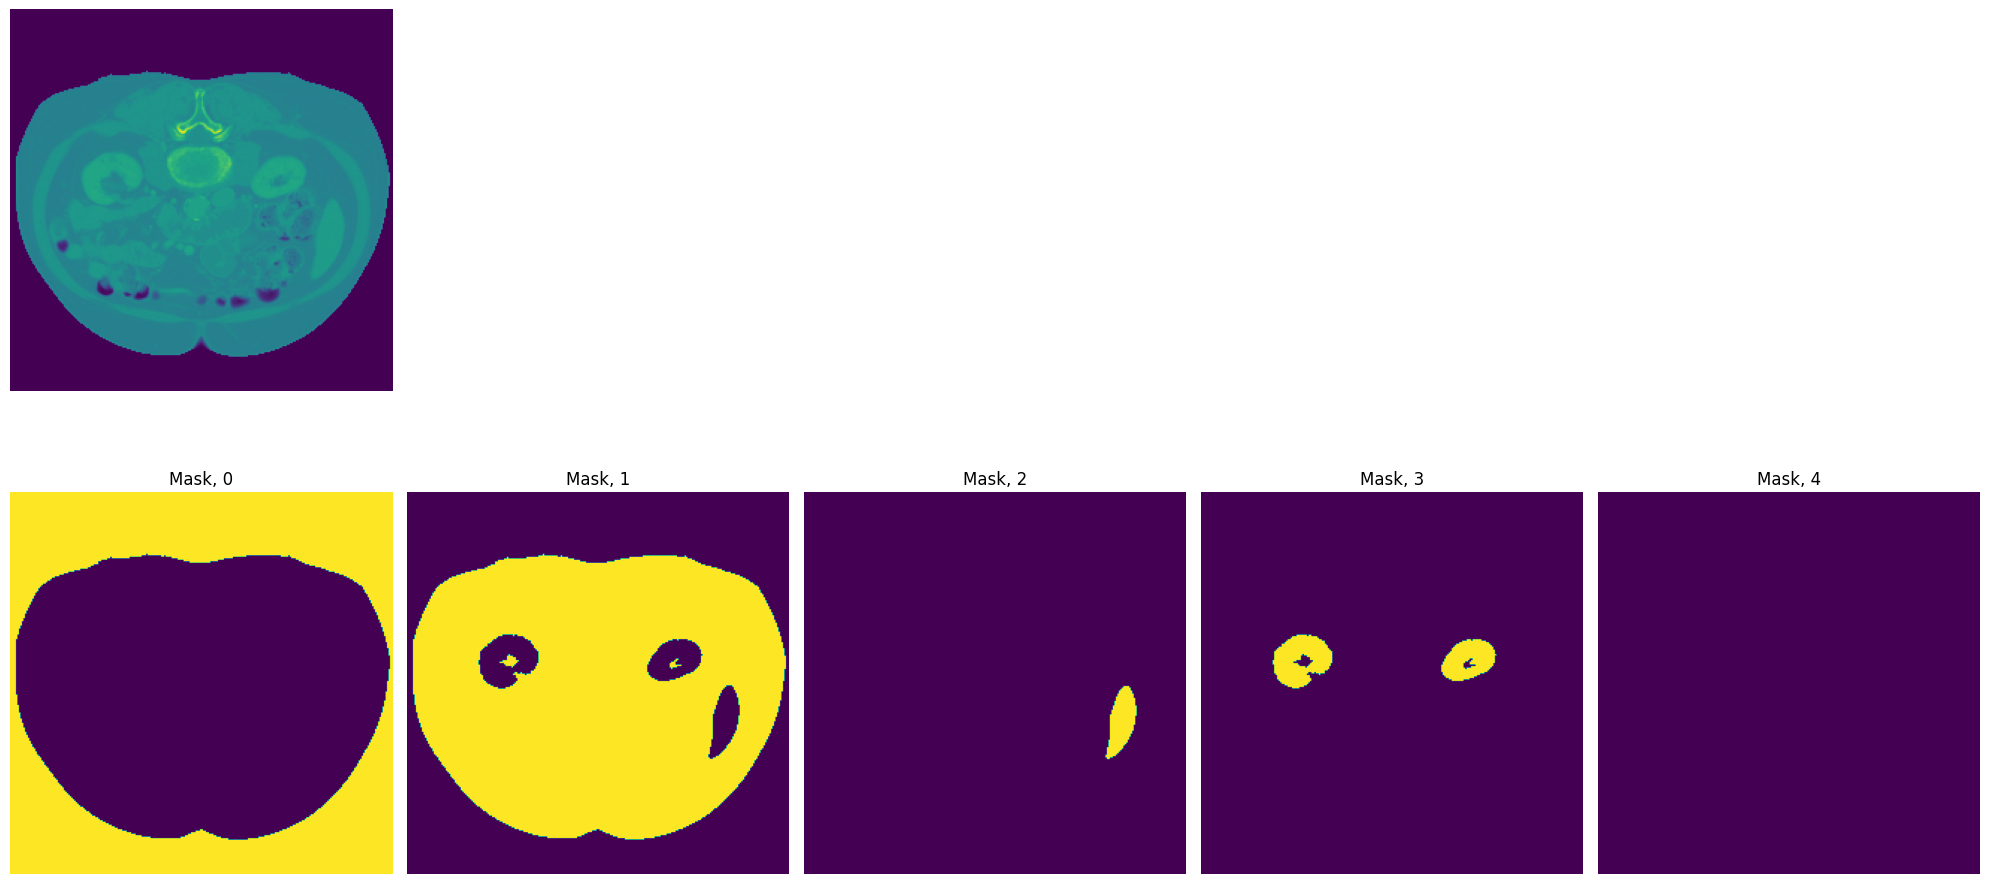

(256, 256, 1) (256, 256, 5)


In [11]:
image, mask = next(iter(train_ds))
plot_example(image, mask)

print(image.shape, mask.shape)

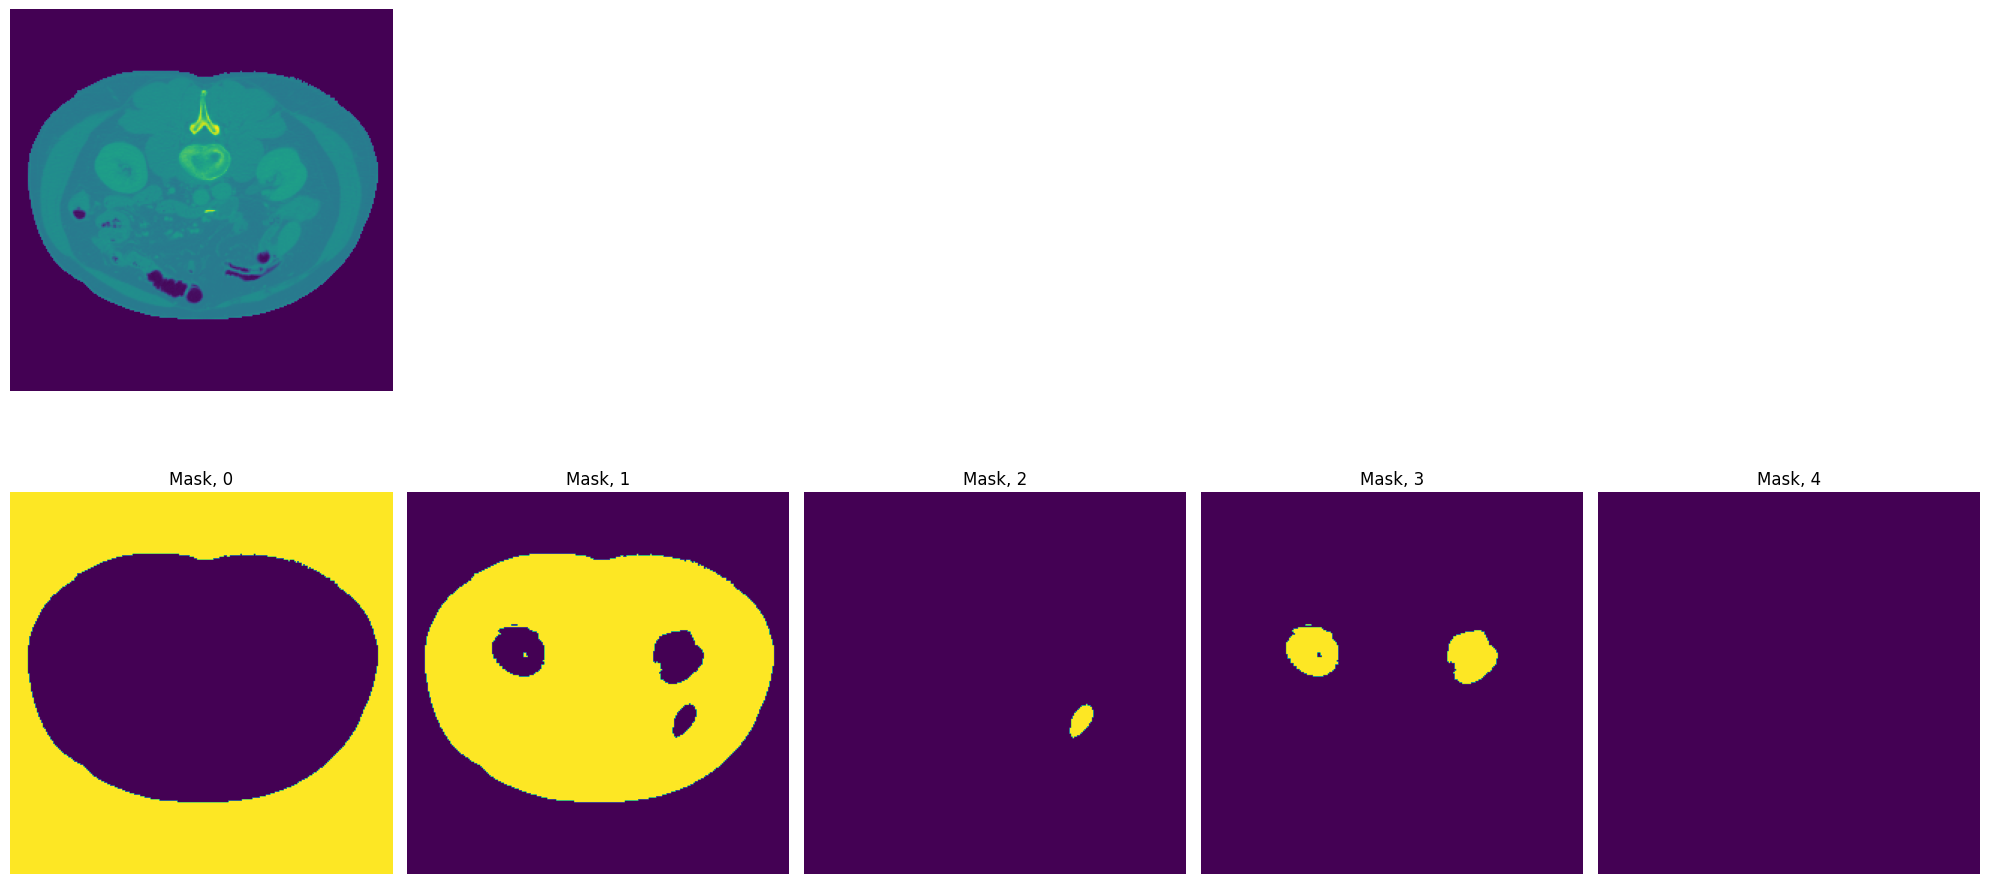

(256, 256, 1) (256, 256, 5)


In [12]:
image, mask = next(iter(valid_ds))
plot_example(image, mask)

print(image.shape, mask.shape)

In [13]:
train_ds = train_ds.shuffle(buffer_size=1000, seed=seed) \
                   .cache() \
                   .batch(batch_size=BATCH_SIZE) \
                   .prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.batch(batch_size=BATCH_SIZE) \
               .cache() \
               .prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
# example batch
ib, mb = next(iter(train_ds))
ib.shape, mb.shape

(TensorShape([32, 256, 256, 1]), TensorShape([32, 256, 256, 5]))

In [15]:
# Definir bloques convolucionales.
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

# Definir bloques convolucionales + max pooling para el codificador.
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPooling2D((2, 2))(x)
    return x, p

# Definir bloques de upsample para el decodificador.
def decoder_block(input, num_filters):
    x = UpSampling2D((2, 2))(input)
    x = conv_block(x, num_filters)
    return x

# Construir la arquitectura SegNet.
def build_segnet(n_classes, input_shape):
    inputs = Input(input_shape)

    # Codificador
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # Decodificador
    d1 = decoder_block(p4, 512)
    d2 = decoder_block(d1, 256)
    d3 = decoder_block(d2, 128)
    d4 = decoder_block(d3, 64)

    outputs = Conv2D(n_classes, (1, 1), padding="same", activation="softmax")(d4)

    model = Model(inputs=[inputs], outputs=[outputs], name="SegNet")
    return model

In [16]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, 1)
model = build_segnet(n_classes,input_shape)
name_model = 'SEGNET-CLASICO'
name_checkpoint = f'{current_path}/{name_model}_5_classes.keras'

keras_metrics = ['accuracy',
                  sm.metrics.iou_score,
                  sm.metrics.dice_score,
                  sm.metrics.f1_score,
                  sm.metrics.f2_score,
                  sm.metrics.precision,
                  sm.metrics.recall,
                  ]

model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=keras_metrics)
model.summary()

Model: "SegNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256, 256, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128, 128, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 128, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 256)    │             

 Total params: 11,742,853 (44.80 MB)

 Trainable params: 11,735,173 (44.77 MB)

 Non-trainable params: 7,680 (30.00 KB)

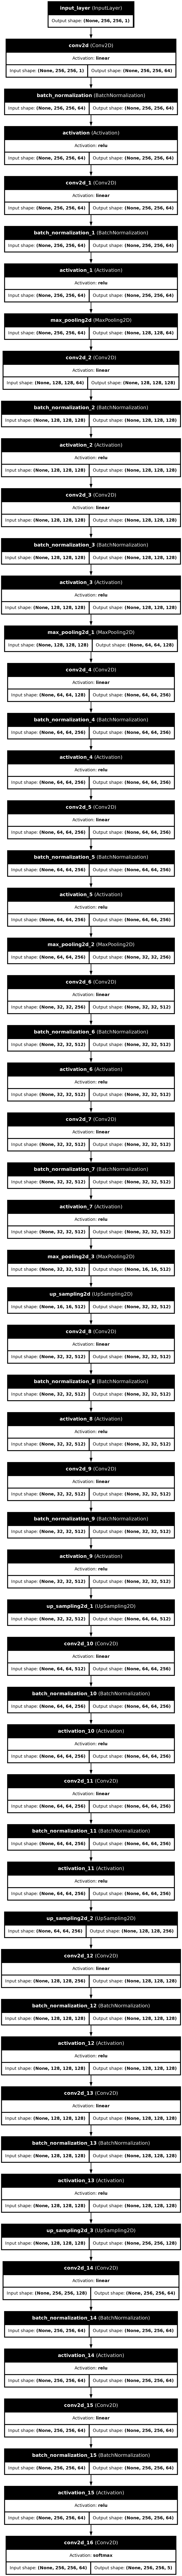

In [17]:
plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
    show_layer_activations=True,
    to_file=f'{current_path}/{name_model}.png',
)

In [ ]:
checkpoint_path = name_checkpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

callbacks = [
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        save_freq='epoch',
    )
]

# train
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/250


2024-06-22 19:43:07.594756: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65536: 1.05936, expected 0.681349
2024-06-22 19:43:07.594803: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65537: 2.21753, expected 1.83952
2024-06-22 19:43:07.594813: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65538: 2.5462, expected 2.16819
2024-06-22 19:43:07.594820: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65539: 2.07291, expected 1.6949
2024-06-22 19:43:07.594832: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65540: 2.56529, expected 2.18728
2024-06-22 19:43:07.594840: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65542: 2.19261, expected 1.8146
2024-06-22 19:43:07.594847: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65543: 1.83463, expected 1.45662
2024-06-22 19:43:07.594855: E

85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 680ms/step - accuracy: 0.8459 - dice_score: 0.4392 - f1-score: 0.4392 - f2-score: 0.4452 - iou_score: 0.3637 - loss: 0.4907 - precision: 0.4485 - recall: 0.4636

2024-06-22 19:45:29.933387: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 1.06306, expected 0.587185
2024-06-22 19:45:29.933441: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 2.37522, expected 1.89934
2024-06-22 19:45:29.933456: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 2.49553, expected 2.01965
2024-06-22 19:45:29.933472: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.35389, expected 1.87801
2024-06-22 19:45:29.933487: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 2.81771, expected 2.34183
2024-06-22 19:45:29.933497: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 2.83996, expected 2.36408
2024-06-22 19:45:29.933509: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 2.48233, expected 2.00645
2024-06-22 19:45:29.933519: E external/local_xla/xla/s

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 915ms/step - accuracy: 0.8467 - dice_score: 0.4401 - f1-score: 0.4401 - f2-score: 0.4461 - iou_score: 0.3646 - loss: 0.4880 - precision: 0.4493 - recall: 0.4644

2024-06-22 19:45:56.521810: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 1.28514, expected 0.771578
2024-06-22 19:45:56.521863: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 2.1253, expected 1.61173
2024-06-22 19:45:56.521872: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 2.51833, expected 2.00477
2024-06-22 19:45:56.521880: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.3986, expected 1.88504
2024-06-22 19:45:56.521888: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 2.46482, expected 1.95126
2024-06-22 19:45:56.521895: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 2.79566, expected 2.2821
2024-06-22 19:45:56.521903: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 2.5201, expected 2.00653
2024-06-22 19:45:56.521911: E external/local_xla/xla/servi

86/86 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.8475 - dice_score: 0.4410 - f1-score: 0.4410 - f2-score: 0.4470 - iou_score: 0.3655 - loss: 0.4854 - precision: 0.4500 - recall: 0.4653 - val_accuracy: 0.2038 - val_dice_score: 0.1265 - val_f1-score: 0.1265 - val_f2-score: 0.1386 - val_iou_score: 0.0821 - val_loss: 174.6604 - val_precision: 0.3316 - val_recall: 0.2416
Epoch 2/250
86/86 ━━━━━━━━━━━━━━━━━━━━ 55s 645ms/step - accuracy: 0.9527 - dice_score: 0.6602 - f1-score: 0.6602 - f2-score: 0.6736 - iou_score: 0.5657 - loss: 0.1219 - precision: 0.6454 - recall: 0.6857 - val_accuracy: 0.6019 - val_dice_score: 0.3050 - val_f1-score: 0.3050 - val_f2-score: 0.3107 - val_iou_score: 0.2170 - val_loss: 1.3919 - val_precision: 0.3582 - val_recall: 0.3923
Epoch 3/250
86/86 ━━━━━━━━━━━━━━━━━━━━ 56s 647ms/step - accuracy: 0.9652 - dice_score: 0.7918 - f1-score: 0.7918 - f2-score: 0.8074 - iou_score: 0.6871 - loss: 0.0843 - precision: 0.7733 - recall: 0.8206 - val_accuracy: 0.7680 - val_dice_sc

In [ ]:
imageb, maskb = next(iter(valid_ds))

for i in range(len(imageb)):
    image, mask = imageb[i], maskb[i]

    pred = model.predict(image[tf.newaxis, ...])[0] # (height, width, n_classes) , in probabilities
    pred = tf.math.argmax(pred, axis=-1) # (height, width) , in classes [0, 1, 2, 3, 4,...]
    pred = tf.cast(tf.one_hot(pred, depth=n_classes), tf.int64) # (height, width, n_classes) , in one hot [0, 0, 0, 0, 1], [0, 1, 0, 0, 0] ...
    name = f"Paciente_{i}"
    plot_example(image, mask, pred,name)

In [ ]:
# Extraer el historial de entrenamiento en un DataFrame
history_df = pd.DataFrame(history.history)

# Mostrar el DataFrame
print(history_df)

# Opcional: Guardar el DataFrame en un archivo CSV
history_df.to_csv('training_metrics.csv', index=False)

In [ ]:
def plot_training_history(history,name):
    """
    Plot the training and validation loss history using Plotly.

    Parameters:
    - history : dict
        A dictionary containing the history of the training and validation losses.
        Typically, this is `history.history` where `history` is the output from a
        training process in libraries like TensorFlow/Keras.

    Returns:
    - A Plotly figure object that can be displayed with `fig.show()`.
    """

    train_loss = history['loss']
    val_loss = history['val_loss']

    train_trace = go.Scatter(
        x=list(range(len(train_loss))),
        y=train_loss,
        mode='lines',
        name='Train Loss',
        line=dict(color='blue')
    )

    val_trace = go.Scatter(
        x=list(range(len(val_loss))),
        y=val_loss,
        mode='lines',
        name='Validation Loss',
        line=dict(color='red')
    )

    # Create layout
    layout = go.Layout(
        title=f'Función de Perdidas en Training y Test {name} - U-Net',
        xaxis=dict(title='Epochs'),
        yaxis=dict(title='Loss'),
        legend=dict(x=0.1, y=1.1, orientation='h')
    )

    # Create figure
    fig = go.Figure(data=[train_trace, val_trace], layout=layout)

    last_train_loss = train_loss[-1]
    last_val_loss   = val_loss[-1]
    fig.add_hline(y=last_train_loss, line_dash="dot", line_color="blue", annotation_text=f"Train Loss: {last_train_loss:.4f}",annotation_position="bottom right")
    fig.add_hline(y=last_val_loss, line_dash="dot", line_color="red", annotation_text=f"Validation Loss: {last_val_loss:.4f}",annotation_position="top right")
    # Adjust size and resolution
    fig.update_layout(width=640, height=480)  # equivalent to a 4x3 figure at 160 dpi
    fig.write_html(f"training_history_{name}.html")
    fig.show()

In [ ]:
import plotly.graph_objects as go
import plotly.express as px
plot_training_history(history.history,'')

In [ ]:
def plot_training_accuracy(history,name):
    """
    Plot the training and validation loss history using Plotly.

    Parameters:
    - history : dict
        A dictionary containing the history of the training and validation losses.
        Typically, this is `history.history` where `history` is the output from a
        training process in libraries like TensorFlow/Keras.

    Returns:
    - A Plotly figure object that can be displayed with `fig.show()`.
    """

    train_acc = history['accuracy']
    val_acc = history['val_accuracy']

    train_trace = go.Scatter(
        x=list(range(len(train_acc))),
        y=train_acc,
        mode='lines',
        name='Train Accuracy',
        line=dict(color='blue')
    )

    val_trace = go.Scatter(
        x=list(range(len(val_acc))),
        y=val_acc,
        mode='lines',
        name='Validation Accuracy',
        line=dict(color='red')
    )

    # Create layout
    layout = go.Layout(
        title=f'Accuracy en Training y Test {name}',
        xaxis=dict(title='Epochs'),
        yaxis=dict(title='Loss'),
        legend=dict(x=0.1, y=1.1, orientation='h')
    )

    # Create figure
    fig = go.Figure(data=[train_trace, val_trace], layout=layout)

    last_train_loss = train_acc[-1]
    last_val_loss   = val_acc[-1]
    fig.add_hline(y=last_train_loss, line_dash="dot", line_color="blue", annotation_text=f"Train Accu: {last_train_loss:.4f}",annotation_position="bottom right")
    fig.add_hline(y=last_val_loss, line_dash="dot", line_color="red", annotation_text=f"Validation Accu: {last_val_loss:.4f}",annotation_position="top right")
    # Adjust size and resolution
    fig.update_layout(width=640, height=480)  # equivalent to a 4x3 figure at 160 dpi
    fig.write_html(f"history_Accuracy_{name}.html")
    fig.show()

In [ ]:
plot_training_accuracy(history.history,'')